In [1]:
%matplotlib inline

In [2]:
### Standard Libraries -----------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import os
import bilby.gw.conversion as conversion
import matplotlib.pyplot as plt
import copy
from  scipy.special import logsumexp, rel_entr
import seaborn as sns
import h5py
import bilby
import pesummary
from scipy import interpolate as interp
import lalsimulation as lalsim
import lal

### Non-standard Libararies -------------------------------------------
import lwp
import lwp.executables.get_files as get_files

from lwp import executables

# Set to true the first time this is run, 
# can be turned off later to save time/bandwidth
download_astro_samples = False
download_eos_samples = False

/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
### Units
gcm3_to_dynecm2=8.9875e20 
MeV_to_gcm3 = 1.7827e12 
dynecm2_to_MeVFermi = 1.6022e33
gcm3_to_fm4 = 3.5178e14
sat_dens = 2.8*(np.power(10.0,14.))
c = bilby.core.utils.speed_of_light

In [4]:
# Download Astrophysical samples and compute the bandwidth for the samples.
# We also get the chirp-mass range and mass-ratio range of the samples, so we can 
# make sure the prior we set is not smaller than the support of the likelihood.
# You can specify a "load_function" which helps the code translate the input format
# given to the common lwp table-column format.  This must be done for public h5 samples
# because of the degeneracy with bilby-format .h5 result files. See `lwp/utils/io.py` 
# for a list of possible load functions. 
# This will also save the samples and .in file by default.

if download_astro_samples:
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    "bilby_results_files_v1.zip", 
    "PE170817_low_spin.csv", 
    download_url="https://dcc.ligo.org/public/0168/P2000193/002/bilby_results_files_v1.zip",
    max_num_pe_samples = 5000,
    load_samples_kwargs = {"load_function": None, "low_spin":True})
    
    # Get the data we need to run lwp_pipe
    astro_prefix= "PE170817_low_spin"
    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

In [5]:
# If the samples are already on disk, no need to download them again,
# we can just read the bandwidth out of the saved file
# (If the samples are already on disk but the .in file doesn't exist, no worries! just 
# call the function above `get_astro_samples` with `download_url` set to `None`, and no 
# extra downloading will be done.)

astro_prefix = "PE170817_low_spin"
event_name = "GW170817_IMRPhenomPv2_NRTidal_lowspin_0_result.json"
if not(download_astro_samples):
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    f"gw_events/{event_name}", ### input here, name of desired file to read in
    f"{astro_prefix}.csv", 
    download_url = None, # No download needed 
    max_num_pe_samples = 5000,
    scan_likelihood = False, # Assume the .in file is stored
    load_samples_kwargs = {}) # The correct loading function will be called on already-processed .csv's
    # Get the data we need to run lwp_pipe
    
    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

successfully got 53609 pe samples,
downsampling to 5000 samples


In [6]:
# Download an example set of EoS's to be used by the LVK in O4
if download_eos_samples:
    samples_url = "https://zenodo.org/record/6502467/files/LCEHL_EOS_posterior_samples_PSR.h5?download=1"
    samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
    !curl {samples_url} -o {samples_file}


In [7]:
# This code defines the needed map from eos-indices to macroscopic m-lambda
# relations.  It also defines which EoS to be used by specifying which integers
# `eos_to_be_used` should be used as keys to the `macro_data` mapping
# For a better resolved run, simply use more EoSs e.g. `eos_to_be_used = np.arange(10000)`.
# You can also use your own EoS set by just creating a `macro_data`
# which maps integers to your M-Lambda curves 
# e.g. macro_data = {eos_num : pd.read_csv(f"my_m_lambda_curve_{eos_num}.csv")}
# just make sure the columns  "M", "Lambda" appear.  

samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
# samples_file =  "full_covariance_example.h5"
samples_tag = "np"
samples  = h5py.File(samples_file)
eos_to_be_used = np.arange(10000)
# eos_to_be_used = np.arange(5206)

### Enumerating Mass-Radius EoS Relation values
macro_data = {eos_num: np.array(samples['ns'][eos_id]) for eos_num, eos_id in enumerate(samples['eos'])}
### Enumerating Pressure-Density Relation values
macro_data2 = {eos_num2 : np.array(samples['eos'][eos_id]) for eos_num2, eos_id in enumerate(samples['eos'])}

In [ ]:
# Compute the likelihoods and marginal likelihoods.
# This is the primary executable of lwp, it computes the likelihoods of each EoS 

result = executables.lwp_pipe(
    eos_indices = np.array(eos_to_be_used),
    retrieve_macro_data = lambda index: macro_data[index], 
    gw_posterior_samples = astro_data,
    likelihood_bandwidth=bandwidth,
    likelihood_prior_key="gauss_mc_flat_q",
    mc_marginalization_range=chirp_mass_range,
    save_likelihoods=f"./{astro_prefix}_post.csv",
    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv")

In [ ]:
# This is, for example, all of the likelihood evaluations L(m1, m2, Lambda(m1, EoS), Lambda(m2, EoS), EoS)
likelihoods= result["likelihood_evaluations"]
likelihoods

***
## Post-analysis Inference

In [9]:
lwp_run = True
verbose = True
astro_prefix = "PE170817"
gw_event = "GW170817"
type_event = "BNS"
eos_type = "GP"

if lwp_run == True:
    weights = pd.read_csv(f"/home/sunny.ng/lwp/lwp_result/{gw_event}_{eos_type}_lwp/result/{gw_event}_{eos_type}_lwp_eos.csv")
    max_logweight = max(weights["logmargweight"])
elif lwp_run != True: ### Loading in weights from a notebook analysis run
    weights = pd.read_csv(f"{astro_prefix}_eos.csv") ### change saved marginalization parameter file name
    max_logweight = max(weights['logmargweight'])
    if verbose == True:
        print(f"Loading weights for event: {astro_prefix}")


# Using EoS information to inform PE for a given event

In [11]:
eos_pe_samples = pd.read_csv(f"/home/sunny.ng/lwp/lwp_result/{gw_event}_{eos_type}_lwp/result/{gw_event}_{eos_type}_lwp_post.csv") # gives dataframe of EoS weighted PE
wts = eos_pe_samples["logweight"]
eos_pe_samples

,eos,m1,m2,Lambda1,Lambda2,logweight
0,0.0,1.402373,1.320337,924.372241,1329.278220,2.008145
1,0.0,1.413156,1.321867,884.294465,1320.568045,2.788525
2,0.0,1.428181,1.306344,828.448322,1421.054693,-0.831213
3,0.0,1.682133,1.120581,275.955290,3363.793958,-80.591080
4,0.0,1.604546,1.172403,385.693105,2627.789050,-0.206369
...,...,...,...,...,...,...
999995,9999.0,1.386135,1.353630,115.329705,131.050925,5.810664
999996,9999.0,1.427443,1.304346,98.016712,159.256210,5.765642
999997,9999.0,1.486742,1.262894,77.971480,188.321620,5.565357
999998,9999.0,1.473632,1.258773,81.964655,191.211275,5.821277


### Component Mass Prior vs Posterior

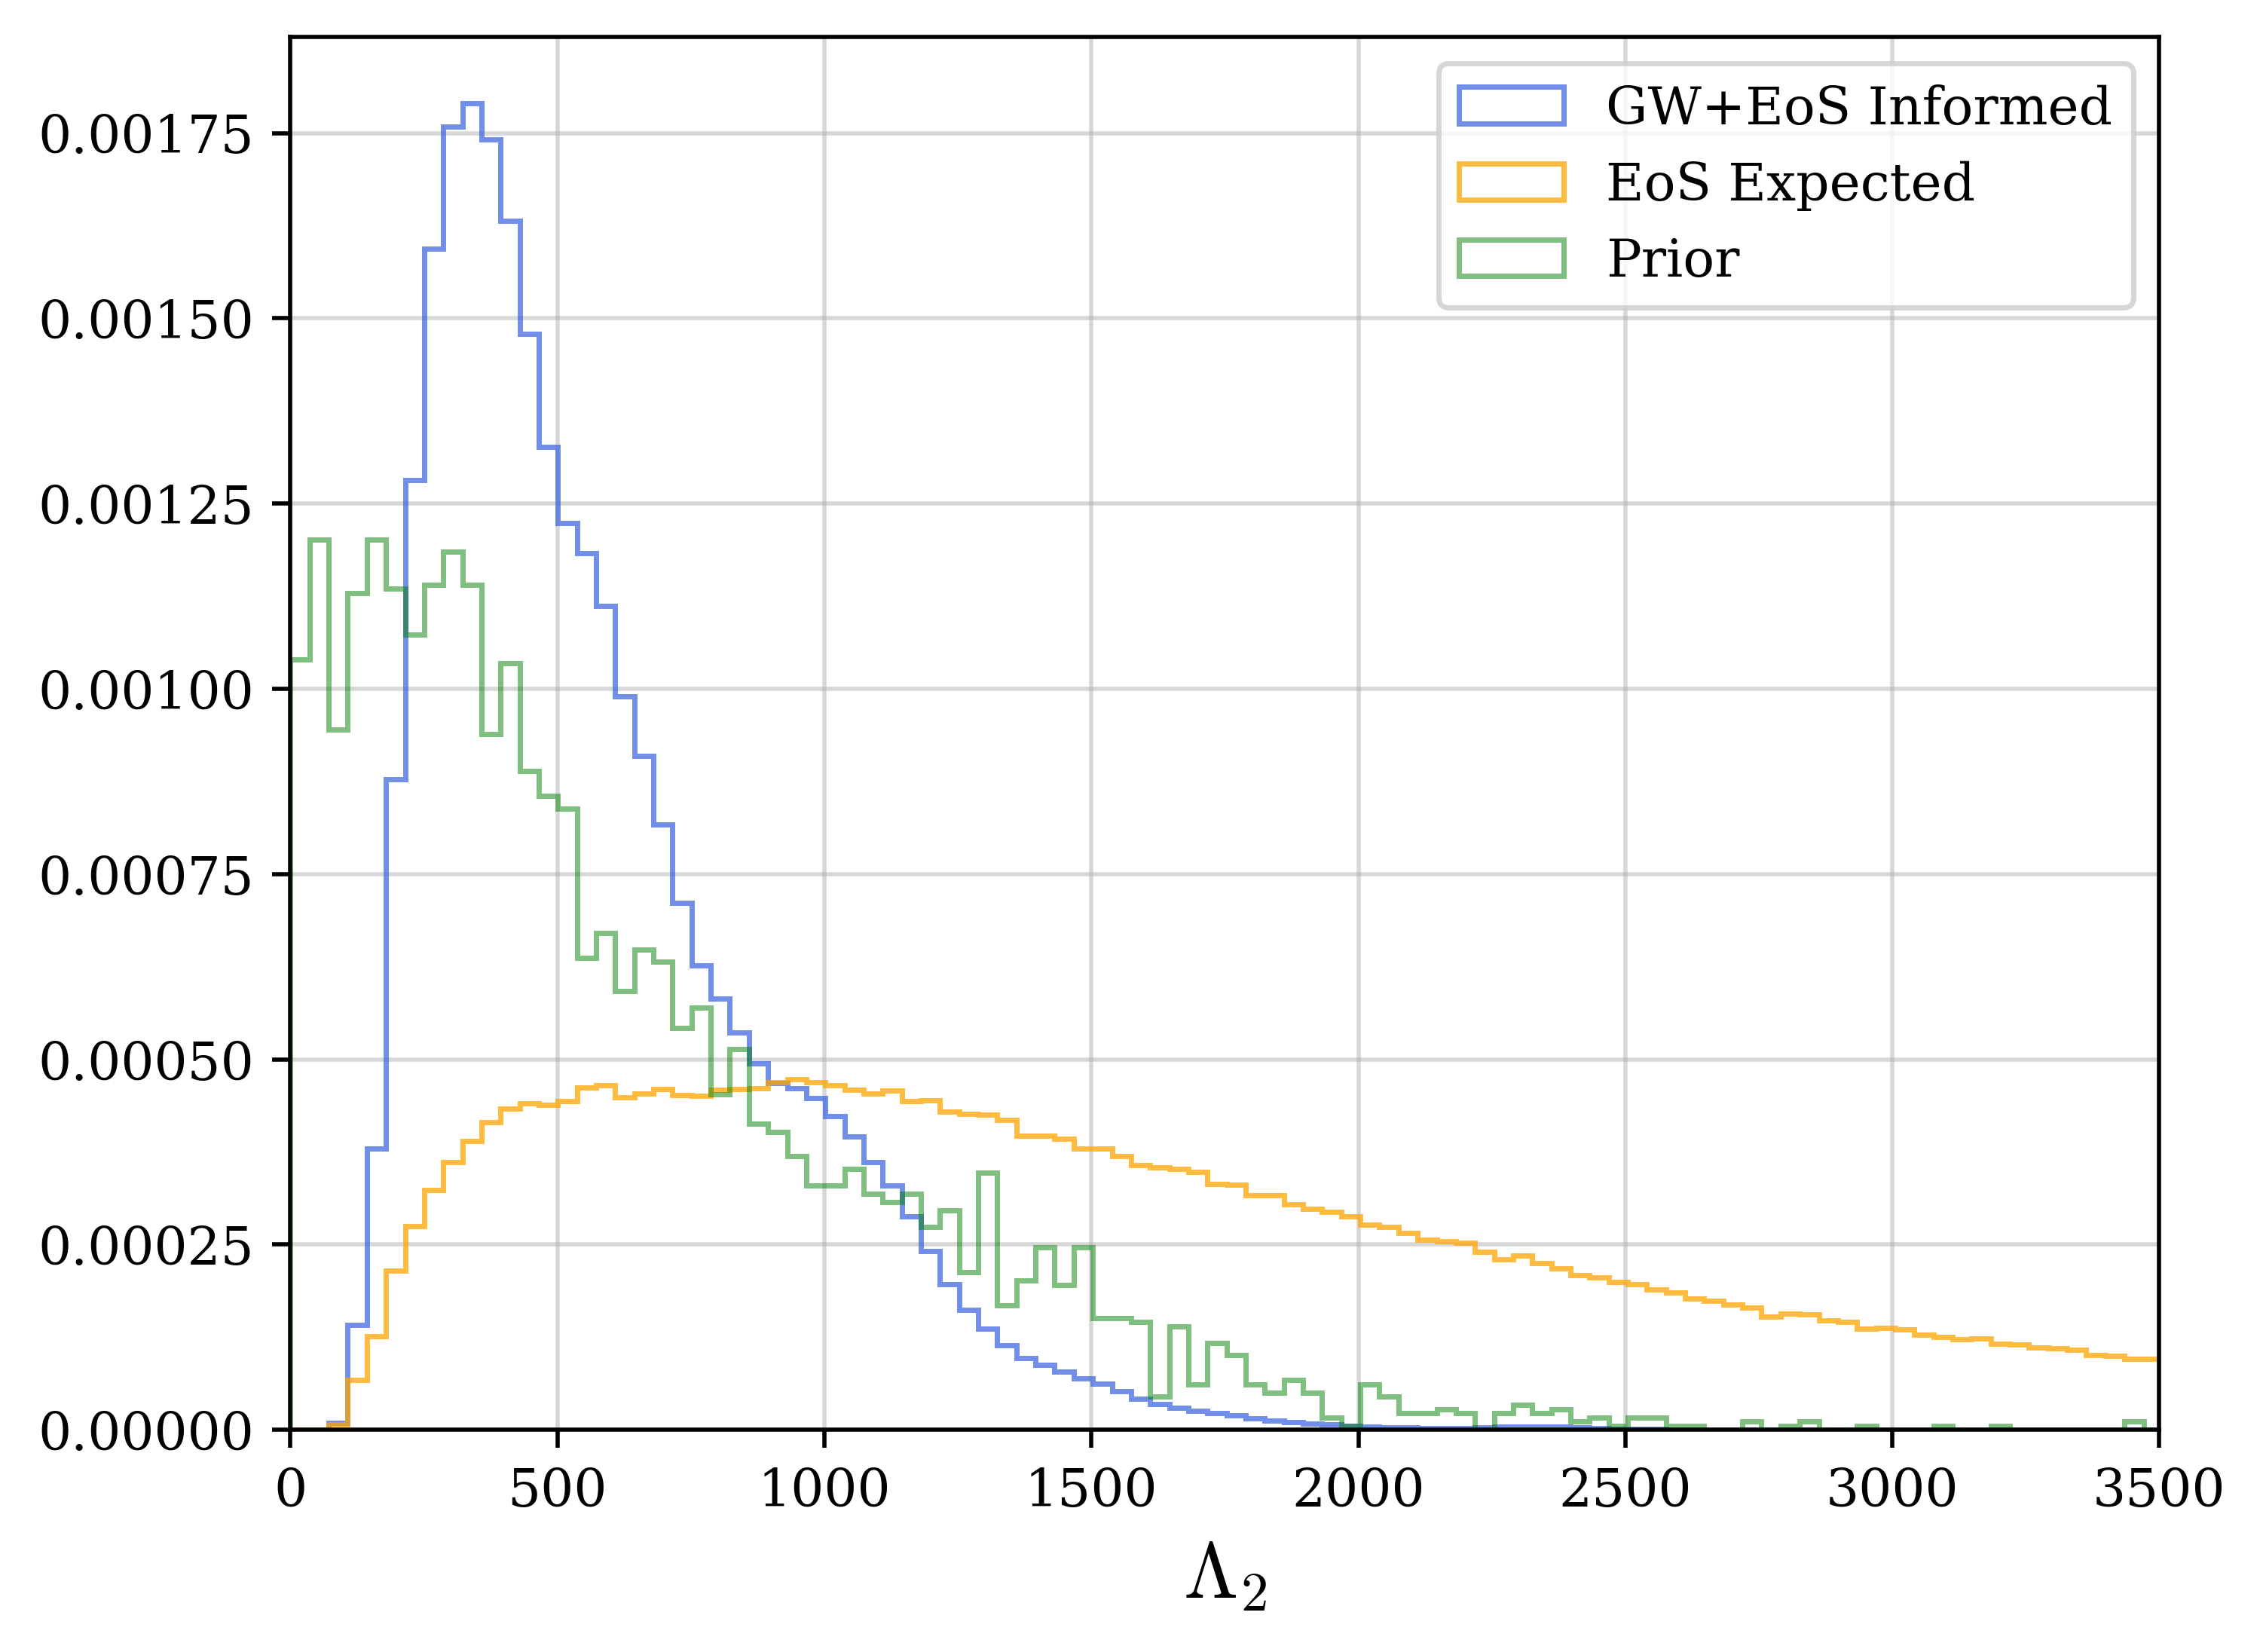

In [24]:
wts = eos_pe_samples["logweight"]
range_for_hist = (min(astro_data["Lambda2"]), max(astro_data["Lambda2"]))
plt.hist(eos_pe_samples["Lambda2"], bins = 100,
         weights = np.exp(eos_pe_samples["logweight"]),
         range = range_for_hist, 
            color = "royalblue", alpha = 0.75, label = "GW+EoS Informed", density = True, histtype="step")
plt.hist(eos_pe_samples["Lambda2"], 
         bins = 100,
          range = range_for_hist, 
            color = "orange", alpha = 0.75, label = "EoS Expected", density = True, histtype="step")
plt.hist(astro_data["Lambda2"], bins = 100, color = "green",
          range = range_for_hist, 
            alpha = 0.5, label = "Prior", density = True, histtype = "step")
plt.xlabel(r"$\Lambda_{2}$", math_fontfamily = "cm", fontsize = 15.)
plt.grid(alpha = 0.5)
plt.xlim(0.0, 3500.0)
plt.legend()
plt.gcf().set_dpi(500)
plt.show()

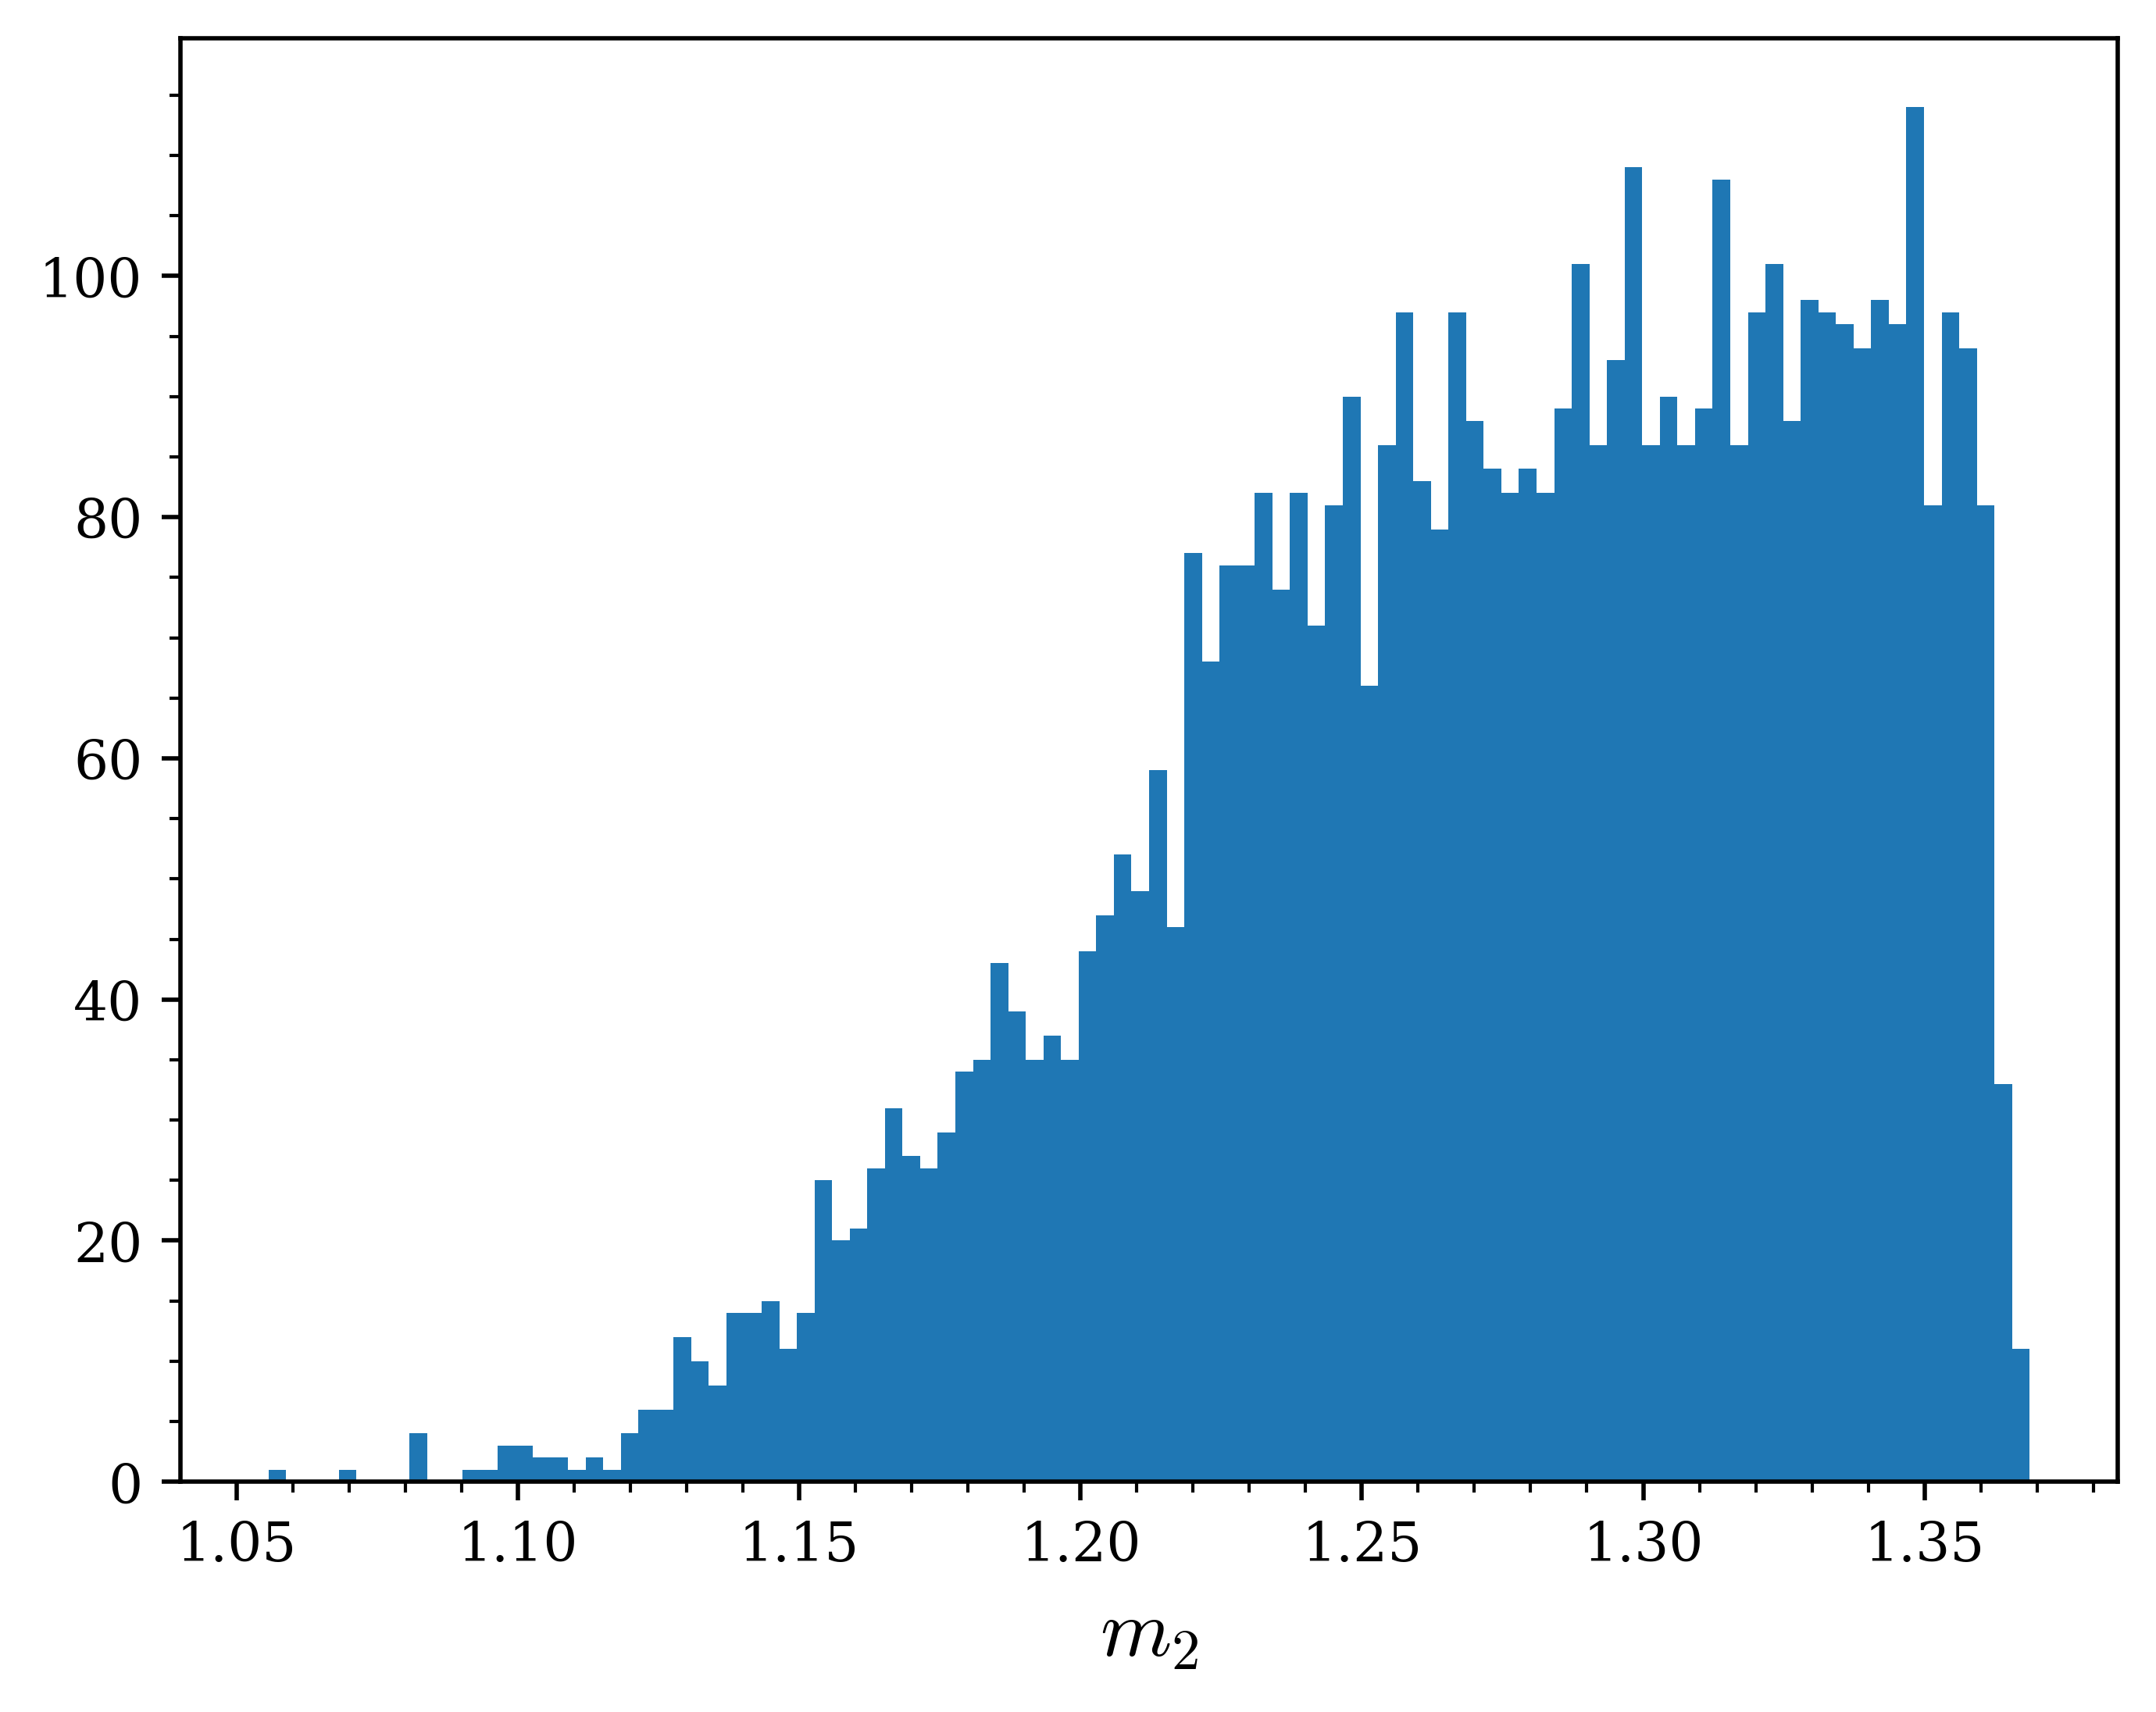

In [31]:
plt.hist(astro_data["m2"], bins = 100)
plt.gcf().set_dpi(500)
plt.xlabel(r"$m_{2}$", math_fontfamily = "cm", fontsize = 15.)
plt.minorticks_on()
plt.show()

/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

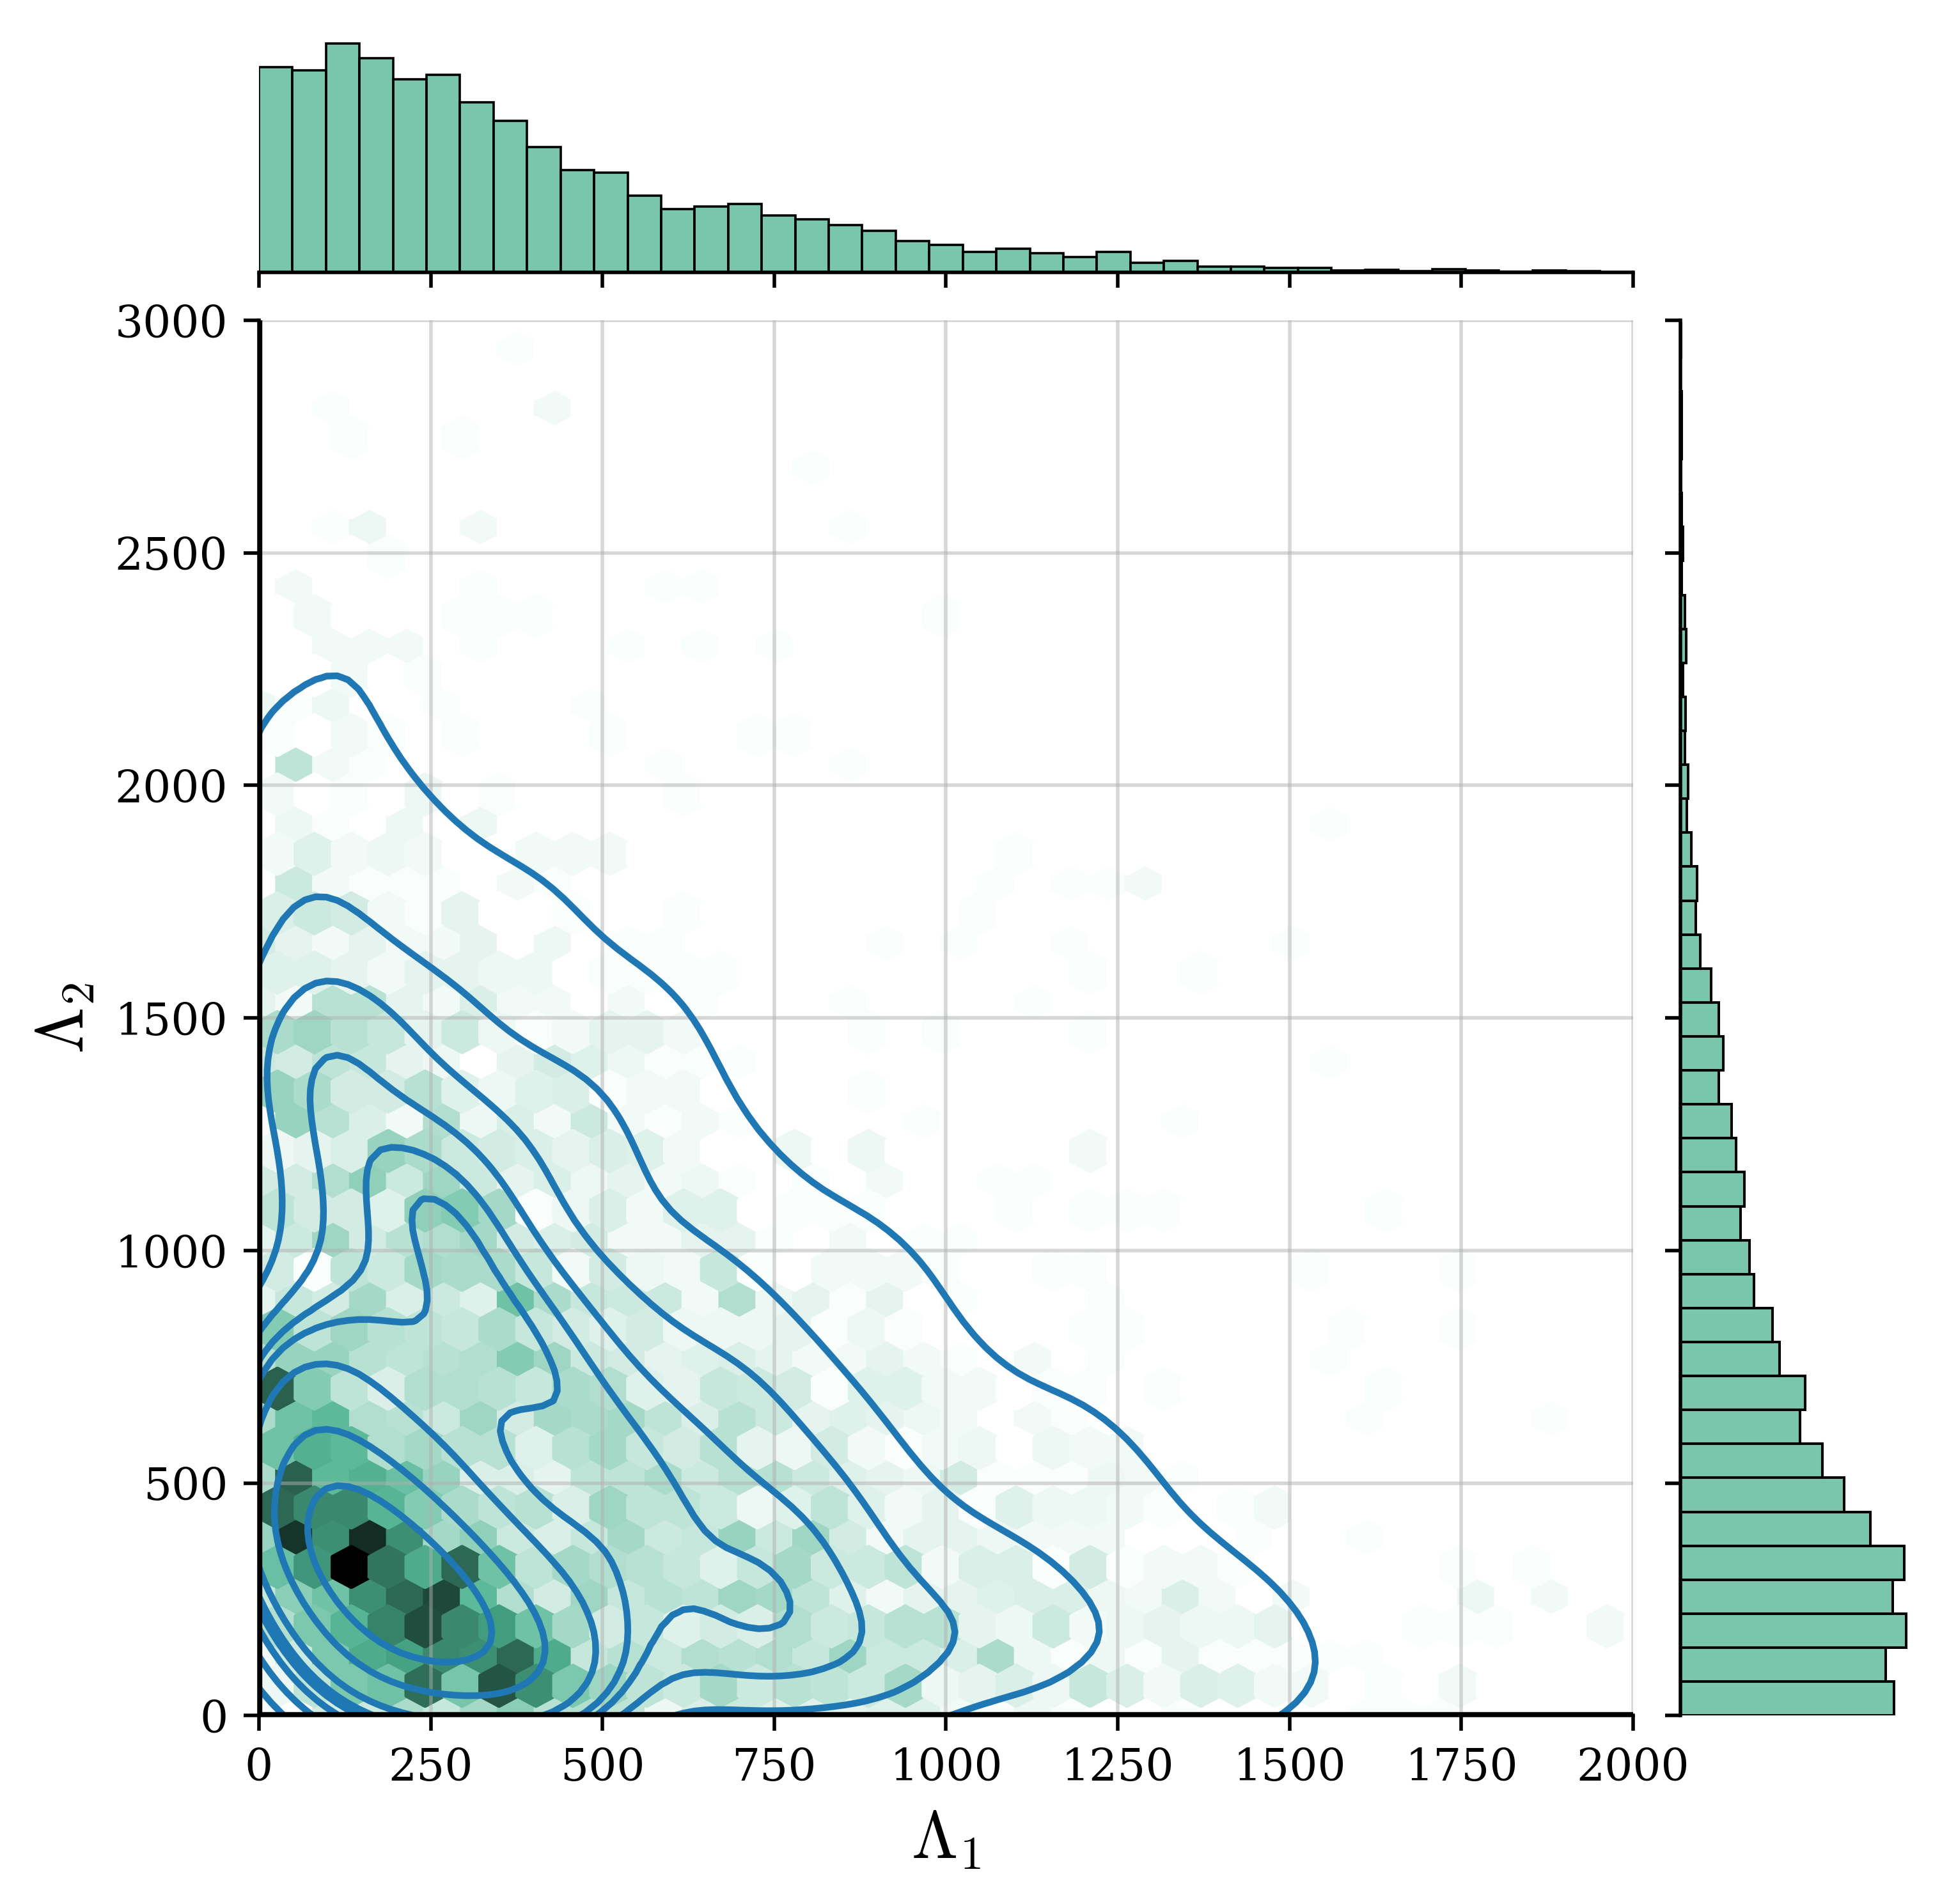

In [20]:
g = sns.jointplot(x=astro_data["Lambda1"], y=astro_data["Lambda2"], kind="hex", color="#4CB391")
g.plot_joint(sns.kdeplot)
plt.xlabel(r"$\Lambda_{1}$",math_fontfamily = "cm", fontsize = 15.)
plt.ylabel(r"$\Lambda_{2}$",math_fontfamily = "cm", fontsize = 15.)
plt.axvline(0.0, color = "k")
plt.axhline(0.0, color = "k")
plt.axis([0.0, 2000., 0.0, 3000.])
plt.grid(alpha = 0.5)
plt.gcf().set_dpi(500)
plt.show()

In [29]:
np.median(eos_pe_samples["m2"])

1.2356698493673615

In [30]:
np.median(astro_data["m2"])

1.2804666920394636

/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sunny.ng/.conda/envs/igwn-py39/lib/python3.9/site-packages/seaborn/_oldcore.py:1075

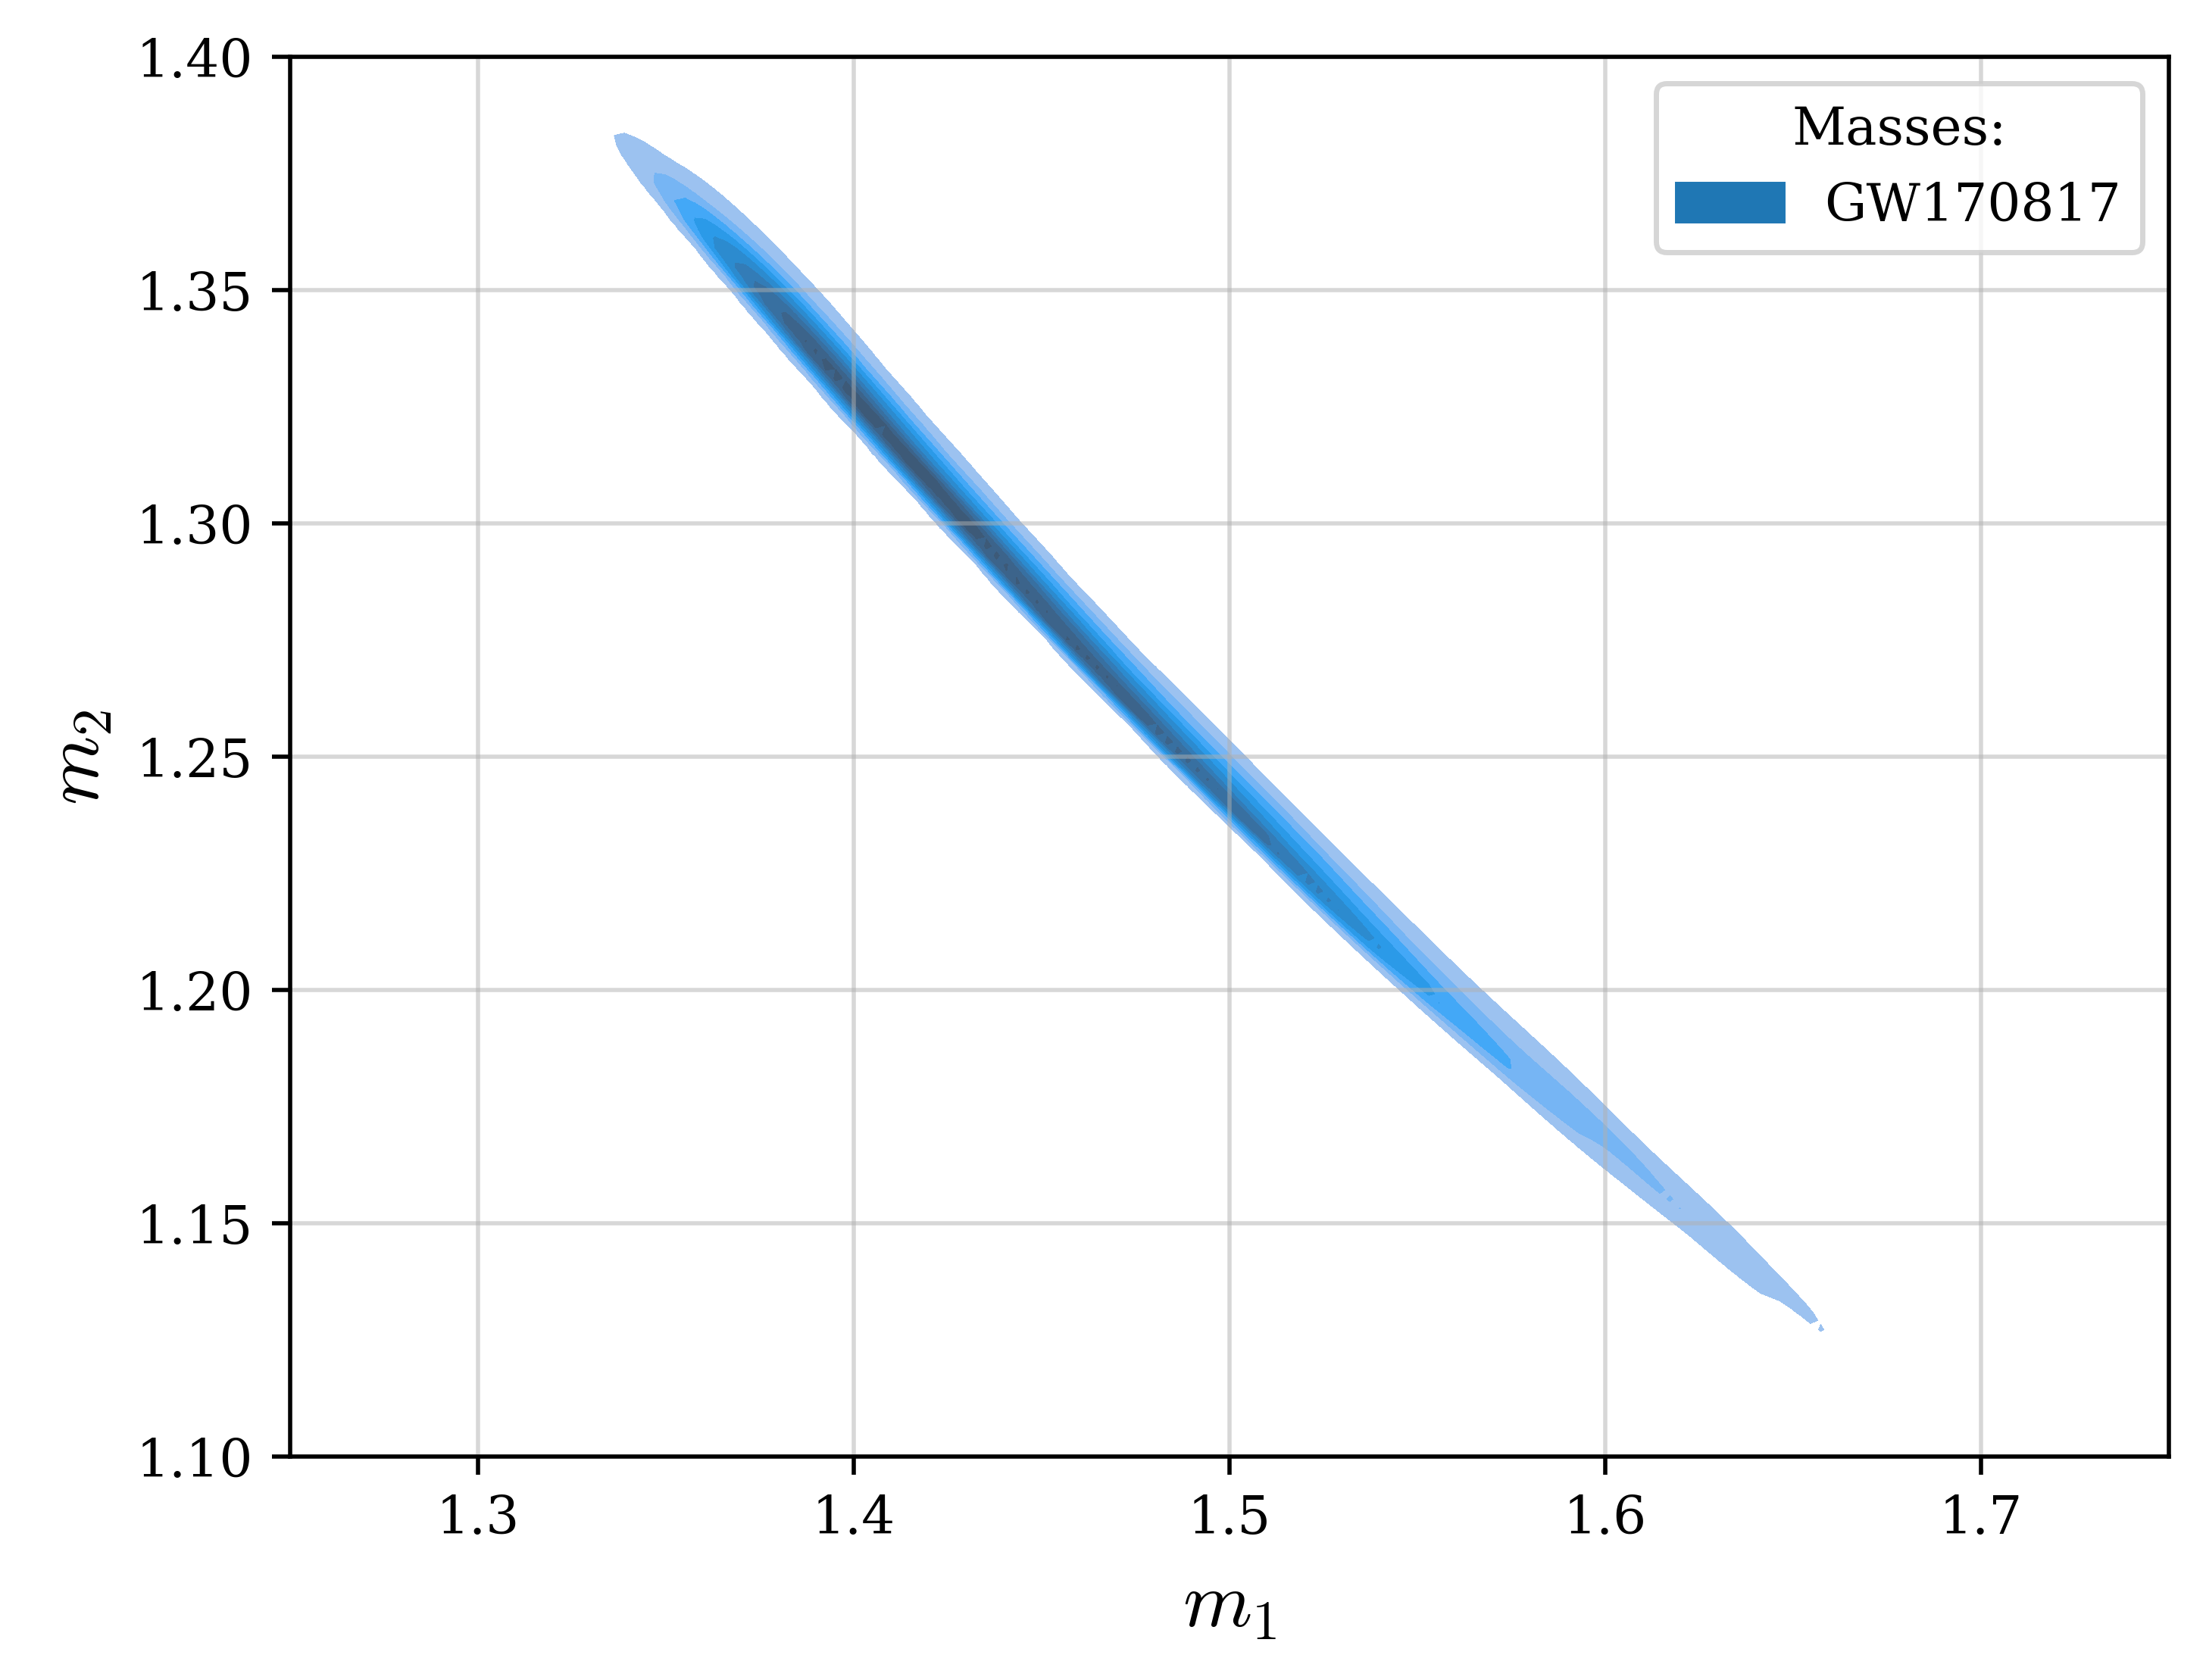

In [27]:
astro_data1 = astro_data["m1"]
astro_data1["Masses:"] = "GW170817"
astro_data2 = astro_data["m2"]

data = pd.concat([astro_data1, astro_data2])
sns.kdeplot(data, x=astro_data['m1'], y=astro_data['m2'], hue='Masses:', color = "green", alpha = 1.0, fill = True)
plt.xlabel(r"$m_{1}$", math_fontfamily = "cm", fontsize = 15.)
plt.ylabel(r"$m_{2}$", math_fontfamily = "cm", fontsize = 15.)
plt.axis([1.25,1.75, 1.1, 1.4])
plt.grid(alpha = 0.5)
plt.gcf().set_dpi(500)
plt.show()

## Sanity check for canonical 1.4 Solar Mass - Tidal values

In [145]:
event = "PEH1L1V1_run_01"
w_01 = pd.read_csv(f"{event}_eos.csv")
event = "PEH1L1V1_run_05"
w_05 = pd.read_csv(f"{event}_eos.csv")
event = "PEH1L1V1_run_18"
w_18 = pd.read_csv(f"{event}_eos.csv")

In [62]:
prior_lambda = []
posterior_lambda = []
for j in range(len(eos_to_be_used)):
    lambda_func = interp.interp1d(macro_data[j]["M"], macro_data[j]["Lambda"])
    canon_lambda = lambda_func([1.4,1.5])
    prior_lambda.append(canon_lambda[0])

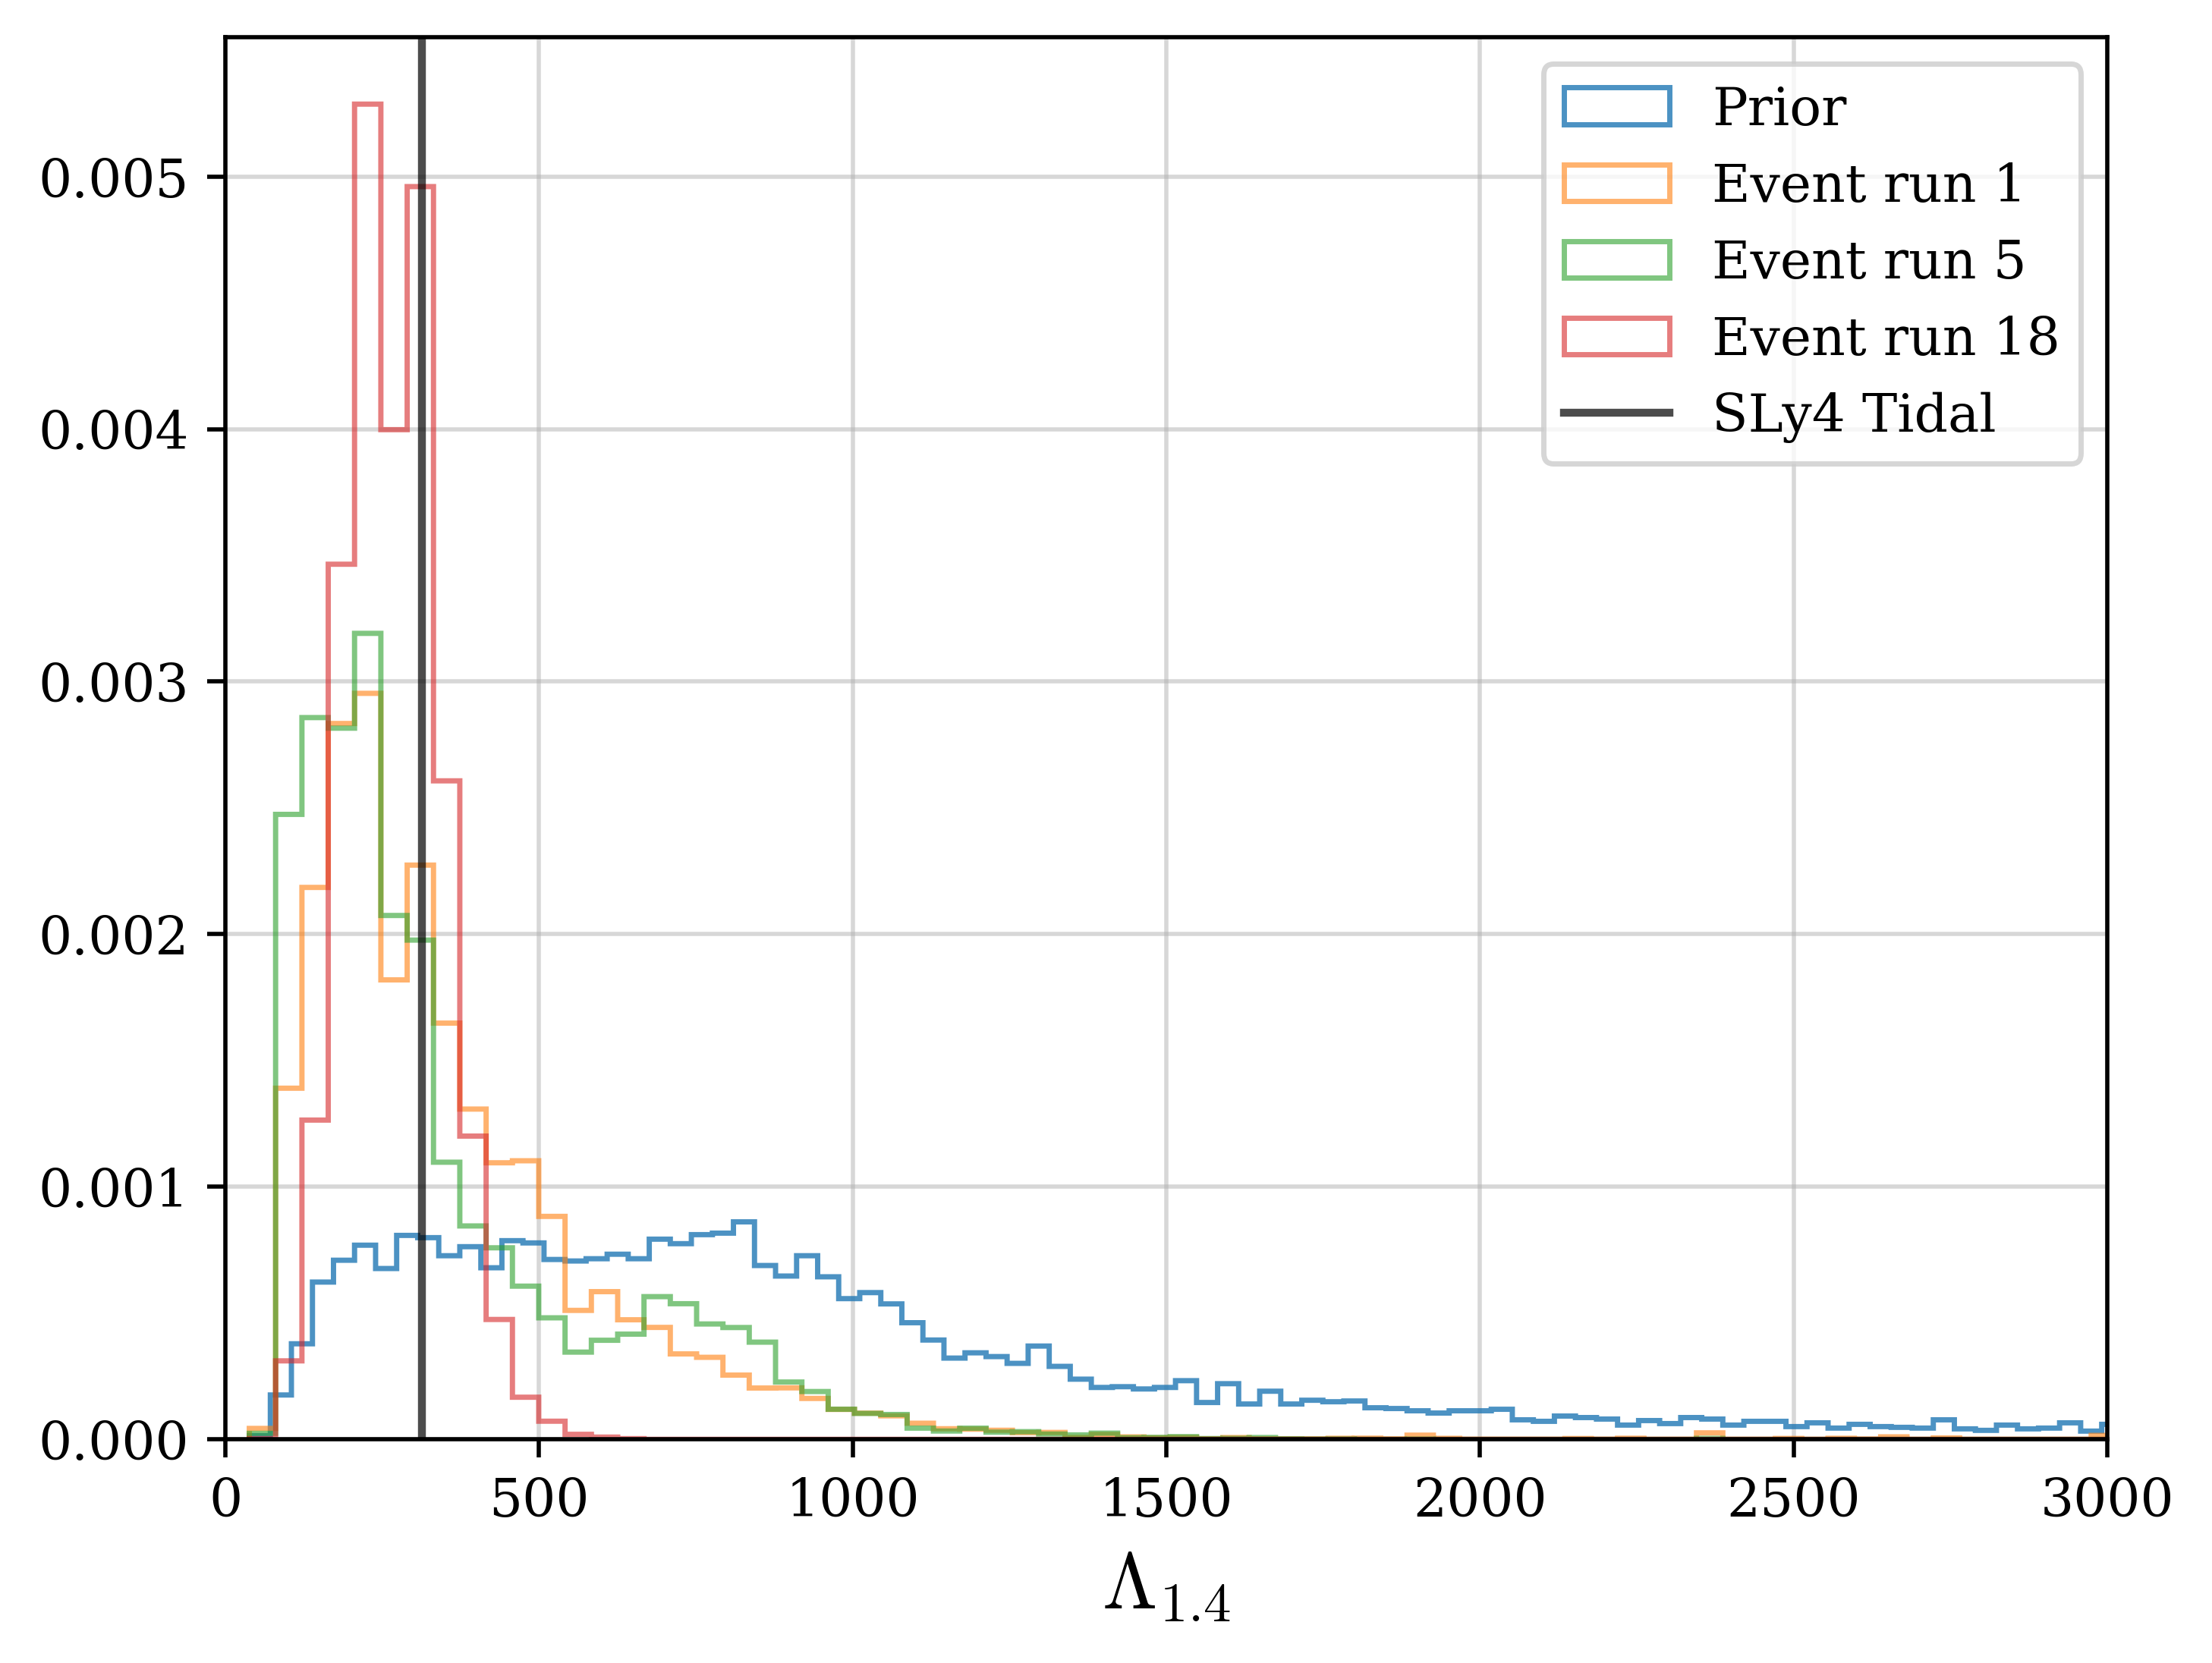

In [184]:
plt.hist(prior_lambda, bins = 1000, density = True, histtype="step", label = "Prior", alpha = .8)
plt.hist(prior_lambda, weights = np.exp(w_01["logmargweight"])/sum(np.exp(w_01["logmargweight"])), bins = 800, density = True, histtype="step", label = "Event run 1", alpha = .6)
plt.hist(prior_lambda, weights = np.exp(w_05["logmargweight"])/sum(np.exp(w_05["logmargweight"])), bins = 800, density = True, histtype="step", label = "Event run 5", alpha = .6)
plt.hist(prior_lambda, weights = np.exp(w_18["logmargweight"])/sum(np.exp(w_18["logmargweight"])), bins = 800, density = True, histtype="step", label = "Event run 18", alpha = .6)
plt.axvline(313.22111061527664, color = "k", label = "SLy4 Tidal", alpha = .7)
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel(r"$\Lambda_{1.4}$", math_fontfamily = "cm", fontsize = 15.)
plt.xlim(0.0,3000.)
plt.gcf().set_dpi(500)
plt.show()

### Importing SLy4 from lalsim:
***

In [93]:
sly4 = "SLY4"
energy_cgs_factor =  pow(lal.C_SI,2) / lal.G_SI / 1000 # kg/m^3 in SI to g/cm^3 in cgs
pressure_cgs_factor =  pow(lal.C_SI,4) / lal.G_SI * 10 # pascals in SI to dyne/ cm^2 in cgs

try:
    sly = lalsim.SimNeutronStarEOSByName(sly4)
except:
    print("EOS did not load.")

In [94]:
fam = lalsim.CreateSimNeutronStarFamily(sly)
refradi = lalsim.SimNeutronStarRadius(lal.MSUN_SI*1.4, fam)
maxenthalpy = lalsim.SimNeutronStarEOSMaxPseudoEnthalpy(sly)
enthalpy = 0.005 #lalsim.SimNeutronStarEOSPseudoEnthalpyOfPressure(1e12 / pressure_cgs_factor, eos) #start
rho = []
press = []
while enthalpy < maxenthalpy:
    pressure = lalsim.SimNeutronStarEOSPressureOfPseudoEnthalpyGeometerized(enthalpy, sly)
    press.append(pressure)
    rho.append(lalsim.SimNeutronStarEOSEnergyDensityOfPressureGeometerized(pressure, sly))
    enthalpy = enthalpy*1.1
sly4_rho = (np.array(rho))*energy_cgs_factor
sly4_press = (np.array(press))*pressure_cgs_factor

In [170]:
k2 = lalsim.SimNeutronStarLoveNumberK2(lal.MSUN_SI*1.4, fam)
rad = lalsim.SimNeutronStarRadius(lal.MSUN_SI*1.4, fam)

In [171]:
rad

11783.433137194492

In [172]:
mass = 1.4*lal.MSUN_SI

In [173]:
sly4_tidal = (2./3.)*k2*(((rad / mass)*(lal.C_SI**2/lal.G_SI))**5)

In [174]:
sly4_tidal

313.22111061527664